<a href="https://colab.research.google.com/github/AnweshaG-29/portfolio-optimization/blob/main/Domestic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


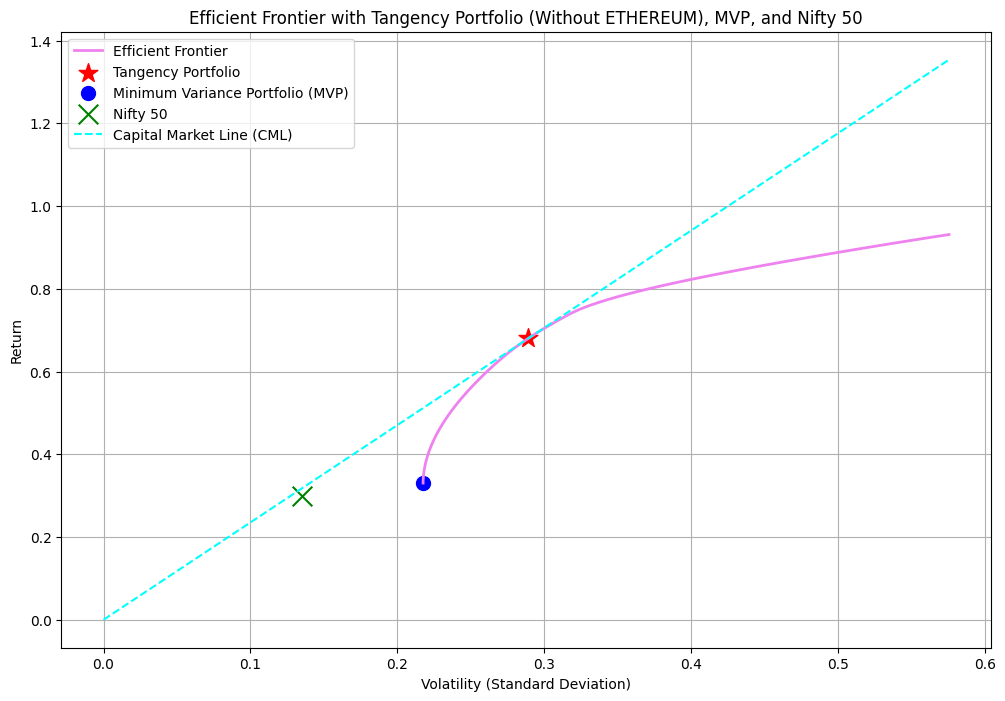

Tangency Portfolio Weights:
APARINDS.NS: 0.00%
ASHOKLEY.NS: 33.84%
ADANIENT.NS: 13.81%
CHEMPLASTS.NS: 31.01%
CAMS.NS: 0.00%
MAPMYINDIA.NS: 21.34%
VARROC.NS: 0.00%
IRFC.NS: 0.00%

Tangency Portfolio Return: 68.02%
Tangency Portfolio Volatility: 28.92%

Minimum Variance Portfolio (MVP) Weights:
APARINDS.NS: 1.78%
ASHOKLEY.NS: 12.54%
ADANIENT.NS: 30.10%
CHEMPLASTS.NS: 10.92%
CAMS.NS: 22.30%
MAPMYINDIA.NS: 0.00%
VARROC.NS: 17.43%
IRFC.NS: 4.94%

MVP Return: 33.05%
MVP Volatility: 21.75%

Expected Nifty 50 Return: 29.86%
Nifty 50 Volatility: 13.49%


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the tickers for the companies and Nifty 50 (^NSEI), excluding Ethereum (ETH-USD)
tickers = ['APARINDS.NS', 'ASHOKLEY.NS', 'ADANIENT.NS', 'CHEMPLASTS.NS', 'CAMS.NS', 'MAPMYINDIA.NS', 'VARROC.NS', 'IRFC.NS']

# Download historical stock data for the given period (for portfolio assets)
data = yf.download(tickers, start='2023-10-01', end='2024-10-01', auto_adjust=False)['Adj Close']

# Also download Nifty 50 data separately to keep it independent
nifty_data = yf.download('^NSEI', start='2023-10-01', end='2024-10-01', auto_adjust=False)['Adj Close']

# Calculate daily returns for the portfolio assets
returns = data.pct_change().dropna()

# Calculate mean returns and covariance matrix (annualized)
mean_returns = returns.mean() * 252  # 252 trading days in a year
cov_matrix = returns.cov() * 252

# Calculate Nifty 50 daily returns (separate from the main portfolio data)
nifty_returns = nifty_data.pct_change().dropna()

# Calculate Nifty 50 annualized return and volatility (independent of other assets)
expected_nifty_return = nifty_returns.mean() * 252
nifty_volatility = np.std(nifty_returns) * np.sqrt(252)

# Risk-free rate (given as 0.0265%)
rf_rate = 0.000257  # Convert percentage to a decimal

# Portfolio performance function: returns, volatility, Sharpe ratio
def portfolio_performance(weights, mean_returns, cov_matrix, rf_rate):
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - rf_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

# Constraint that the sum of weights must be 1 (fully invested portfolio)
def check_sum(weights):
    return np.sum(weights) - 1

# Function to minimize variance for Minimum Variance Portfolio (MVP)
def minimize_variance(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix, rf_rate)[1]

# Set bounds for the weights (between 0 and 1)
bounds = tuple((0, 1) for asset in range(len(tickers)))

# Initial guess (equal weights)
initial_guess = len(tickers) * [1. / len(tickers)]

# Optimization to find Minimum Variance Portfolio (MVP)
mvp_results = minimize(minimize_variance, initial_guess,
                       args=(mean_returns, cov_matrix),
                       method='SLSQP', bounds=bounds,
                       constraints={'type': 'eq', 'fun': check_sum})

# Optimal weights for the MVP
mvp_weights = mvp_results.x
mvp_return, mvp_volatility, _ = portfolio_performance(mvp_weights, mean_returns, cov_matrix, rf_rate)

# Efficient Frontier calculation (minimizing volatility for different returns)
def efficient_frontier(mean_returns, cov_matrix, return_target):
    # Constraints: the sum of weights = 1 and portfolio return = return_target
    constraints = [{'type': 'eq', 'fun': check_sum},
                   {'type': 'eq', 'fun': lambda weights: portfolio_performance(weights, mean_returns, cov_matrix, rf_rate)[0] - return_target}]

    # Minimize portfolio variance (volatility)
    result = minimize(minimize_variance, initial_guess,
                      args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result

# Generate points on the Efficient Frontier
target_returns = np.linspace(mvp_return, max(mean_returns), 100)  # Generate target returns
frontier_volatility = []
frontier_return = []

for return_target in target_returns:
    result = efficient_frontier(mean_returns, cov_matrix, return_target)
    if result.success:
        frontier_volatility.append(portfolio_performance(result.x, mean_returns, cov_matrix, rf_rate)[1])
        frontier_return.append(return_target)

# Optimization to maximize Sharpe ratio (Tangency Portfolio)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, rf_rate):
    return -portfolio_performance(weights, mean_returns, cov_matrix, rf_rate)[2]

opt_results = minimize(negative_sharpe_ratio, initial_guess,
                       args=(mean_returns, cov_matrix, rf_rate),
                       method='SLSQP', bounds=bounds,
                       constraints={'type': 'eq', 'fun': check_sum})

# Optimal weights for the Tangency Portfolio
optimal_weights = opt_results.x
tangency_return, tangency_volatility, tangency_sharpe = portfolio_performance(optimal_weights, mean_returns, cov_matrix, rf_rate)

# Plotting
plt.figure(figsize=(12, 8))

# Plot the Efficient Frontier (as a purple line)
plt.plot(frontier_volatility, frontier_return, color='violet', linewidth=2, label='Efficient Frontier')

# Highlight the Tangency Portfolio
plt.scatter(tangency_volatility, tangency_return, marker='*', color='r', s=200, label='Tangency Portfolio')

# Plot the Minimum Variance Portfolio (MVP)
plt.scatter(mvp_volatility, mvp_return, color='blue', marker='o', s=100, label='Minimum Variance Portfolio (MVP)')

# Plot the Nifty 50 point (independent calculation)
plt.scatter(nifty_volatility, expected_nifty_return, marker='x', color='green', s=200, label='Nifty 50')

# Plot Capital Market Line (CML)
cml_x = np.linspace(0, max(frontier_volatility), 100)
cml_y = rf_rate + tangency_sharpe * cml_x
plt.plot(cml_x, cml_y, label='Capital Market Line (CML)', color='cyan', linestyle='--')

# Plot settings
plt.title('Efficient Frontier with Tangency Portfolio (Without ETHEREUM), MVP, and Nifty 50')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

# Print results for the Tangency Portfolio and MVP
print('Tangency Portfolio Weights:')
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {optimal_weights[i]:.2%}")

print(f"\nTangency Portfolio Return: {tangency_return:.2%}")
print(f"Tangency Portfolio Volatility: {tangency_volatility:.2%}")


print('\nMinimum Variance Portfolio (MVP) Weights:')
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {mvp_weights[i]:.2%}")

print(f"\nMVP Return: {mvp_return:.2%}")
print(f"MVP Volatility: {mvp_volatility:.2%}")

# Print the Nifty 50 expected return (calculated independently)
expected_nifty_return_value = expected_nifty_return.iloc[0]
print(f"\nExpected Nifty 50 Return: {expected_nifty_return_value:.2%}")
nifty_volatility_value = nifty_volatility.iloc[0]  # or .values[0] if it's a numpy array
print(f"Nifty 50 Volatility: {nifty_volatility_value:.2%}")

